## Neural style transfer

Deep learning to compose one image in style of another image. It's an optimization technique used to take two images - a *content* image and a style *reference* image and blend them together so the output image looks like a content image, but painted in style of style reference image.

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time, functools, matplotlib, os

matplotlib.rcParams["figure.figsize"] = (12, 12)
matplotlib.rcParams["axes.grid"] = False

os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphviz2.38/bin/"

In [3]:
def tensor_to_image(tensor):
   tensor = tensor * 255
   tensor = np.array(tensor, dtype = np.uint8)
   
   if np.ndim(tensor) > 3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
   
   return PIL.Image.fromarray(tensor)

In [4]:
content_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
style_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

content_dir = tf.keras.utils.get_file(
   "YellowLabradorLooking_new.jpg",
   content_url
)

style_dir = tf.keras.utils.get_file(
   "Vassily_Kandinsky%2C_1913_-_Composition_7",
   style_url
)

## Visualise the image

In [5]:
def load_image(image_path, max_dim = 512):
   # read content of file as a tensor string
   img = tf.io.read_file(image_path)
   # detect image format and convert string into tensor
   img = tf.image.decode_image(img, channels = 3)
   # convert image into dtype, scaling its value if needed
   img = tf.image.convert_image_dtype(img, tf.float32)
   
   # get a 2d representation of the image (width and height)
   # tf.shape return a 1D integer tensor representing shape
   # of the input
   # tf.shape[0] gives tensor shape information
   # tf.shape[1] gives dtype information
   # tf.shape[2] gives numpy array information (tensor dim)
   shape = tf.cast(
      tf.shape(img)[:-1], 
      tf.float32
   )
   
   # scaling factor is obtained by dividing the desired dim
   # with the longest 2D dimension of the image array
   long_dim = max(shape)
   scale = max_dim/long_dim
   
   # get the new shape where the longest dimension of the
   # original image will become the scaling factor
   new_shape = tf.cast(shape * scale, tf.int32)
   
   # resize the image
   img = tf.image.resize(img, new_shape)
   # wrap by another dimension (Frame, Width, Height, Channel)
   img = img[tf.newaxis, :]
   return img

def imshow(image, title = None):
   # if image is represented as 4D array, remove the frame dim
   if len(image.shape) > 3:
      image = tf.squeeze(image, axis = 0)
      
      plt.imshow(image)
      if title:
         plt.title(title)

In [6]:
content_image = load_image(content_dir)
style_image = load_image(style_dir)

plt.figure()
plt.subplot(1, 2, 1)
imshow(content_image, "Content image")
plt.subplot(1, 2, 2)
imshow(style_image, "Style image")

## Define content and style representation

Use intermediate layers of any neural networks model to get the content and style representation of the image.

Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. Going deeper into the network, the final few layers represent higher-level features of the images.

VGG19 network architecture will be used where its intermediate layers will be used to define the representation of content and styles from the images.

In [7]:
# adequate image to the format required by the model
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))

# load model
vgg = tf.keras.applications.VGG19(
   include_top = True,
   weights = "imagenet"
)

In [8]:
tf.keras.utils.plot_model(
   vgg,
   show_shapes = True,
   expand_nested = True
)

In [9]:
prediction_probabilities = vgg(x)
result = tf.keras.applications.vgg19.decode_predictions(
   prediction_probabilities.numpy()
)[0]

[(class_name, prob) for (number, class_name, prob) in result]

[('Labrador_retriever', 0.49317262),
 ('golden_retriever', 0.23665187),
 ('kuvasz', 0.036357313),
 ('Chesapeake_Bay_retriever', 0.024182774),
 ('Greater_Swiss_Mountain_dog', 0.018646035)]

Choose intermediate layers from the network to represent the style and content of the image.

In [10]:
# content layer where feature maps will be pulled
content_layers = ["block5_conv2"]

# style layers of interes
style_layers = [
   "block1_conv1",
   "block2_conv1",
   "block3_conv1",
   "block4_conv1",
   "block5_conv1"
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
   # Creates a vgg model that returns a list of intermediate 
   # output values.
   # Load our model. Load pretrained VGG, trained on 
   # imagenet data
   
   vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
   vgg.trainable = False
  
   # break the output at the final style layers
   outputs = [
      vgg.get_layer(name).output for name in layer_names
   ]
   
   # recombine input and putput into new model
   model = tf.keras.Model([vgg.input], outputs)
   return model

In [12]:
type(style_image)

tensorflow.python.framework.ops.EagerTensor

In [13]:
# create model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [14]:
tf.keras.utils.plot_model(
   style_extractor,
   show_shapes = True,
   expand_nested = True
)

In [15]:
attrs = vars(style_extractor)
print('\n '.join("%s: %s" % item for item in attrs.items()))

_self_setattr_tracking: True
 _nested_outputs: [<tf.Tensor 'block1_conv1_1/Identity:0' shape=(None, None, None, 64) dtype=float32>, <tf.Tensor 'block2_conv1_1/Identity:0' shape=(None, None, None, 128) dtype=float32>, <tf.Tensor 'block3_conv1_1/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_1/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1_1/Identity:0' shape=(None, None, None, 512) dtype=float32>]
 _nested_inputs: Tensor("input_2:0", shape=(None, None, None, 3), dtype=float32)
 inputs: [<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>]
 outputs: [<tf.Tensor 'block1_conv1_1/Identity:0' shape=(None, None, None, 64) dtype=float32>, <tf.Tensor 'block2_conv1_1/Identity:0' shape=(None, None, None, 128) dtype=float32>, <tf.Tensor 'block3_conv1_1/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_1/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_c

In [16]:
# Look at the statistics of each layer's output
# loop over the tuple of layer and style
for name, output in zip(style_layers, style_outputs):
   print(name)
   print("  shape: ", output.numpy().shape)
   print("  min: ", output.numpy().min())
   print("  max: ", output.numpy().max())
   print("  mean: ", output.numpy().mean())
   print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



## Style computation

The content of the image is represented by the values of the intermediate feature maps.

Style of an image can be described by the means and correlations across the different feature maps. Calculate *Gram Matrix* that includes this information by taking the outer product of the feature vector with itself at each location, and averaging the outer product over all locations.

$$G^{l}_{cd} = \frac{\sum{F^l_{ijc}(x)}\sum{F^l_{ijd}(x)}}{IJ}$$

Tensor contraction over specified indicies and outer product. ```tf.einsum```, ```tf.linalg.einsum```

This function return sa tensor whose elements are defined by ```equation``` which is written as Einstein notation.

As example, consider multiplying 2 matrices $A$ and $B$ to form a matrix $C$. The element of $C$ are given by:
```C[i, k] = sum_j A[i, j] * B[j, k]``` (```sum_j``` is $\sum_j{}$)

The corresponding ```equation``` is
```ij, jk -> ik```

In [17]:
def gram_matrix(input_tensor):
   result = tf.linalg.einsum(
      "bijc, bijd -> bcd",
      input_tensor,
      input_tensor
   )
   
   input_shape = tf.shape(input_tensor)
   
   num_locations = tf.cast(
      input_shape[1] * input_shape[2],
      tf.float32
   )
   
   return result/num_locations

In [18]:
# check properties of keras model
attrs = vars(tf.keras.models.Model)
dir(attrs)

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'copy',
 'get',
 'items',
 'keys',
 'values']

In [19]:
class StyleContentModel(tf.keras.models.Model):
   def __init__(self, style_layers, content_layers):
      super(StyleContentModel, self).__init__()
      
      self.vgg =  vgg_layers(style_layers + content_layers)
      self.style_layers = style_layers
      self.content_layers = content_layers
      self.num_style_layers = len(style_layers)
      self.vgg.trainable = False

   def call(self, inputs):
      inputs = inputs*255.0
      preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
      outputs = self.vgg(preprocessed_input)
      style_outputs, content_outputs = (
         outputs[:self.num_style_layers], 
         outputs[self.num_style_layers:]
      )
      
      style_outputs = [
         gram_matrix(style_output) for style_output in style_outputs
      ]

      content_dict = {
         content_name:value for content_name, value in zip(
            self.content_layers, content_outputs
         )
      }

      style_dict = {
         style_name:value for style_name, value in zip(
            self.style_layers, style_outputs
         )
      }

      return {
         'content':content_dict, 
         'style':style_dict
      }

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
   print("  ", name)
   print("    shape: ", output.numpy().shape)
   print("    min: ", output.numpy().min())
   print("    max: ", output.numpy().max())
   print("    mean: ", output.numpy().mean())
   print()

print("Contents:")
for name, output in sorted(results['content'].items()):
   print("  ", name)
   print("    shape: ", output.numpy().shape)
   print("    min: ", output.numpy().min())
   print("    max: ", output.numpy().max())
   print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522847
    max:  28014.559
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764152


In [21]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [22]:
# set tensor image
image = tf.Variable(content_image)

In [23]:
# Given a tensor t, this operation returns a tensor of the same 
# type and shape as t with its values clipped to clip_value_min 
# and clip_value_max. Any values less than clip_value_min are set 
# to clip_value_min. Any values greater than clip_value_max are 
# set to clip_value_max.

def clip_0_1(image):
   return tf.clip_by_value(
      image, 
      clip_value_min=0.0, 
      clip_value_max=1.0
   )

In [24]:
# set loss function
opt = tf.optimizers.Adam(
   learning_rate=0.02, 
   beta_1=0.99, 
   epsilon=1e-1
)

In [25]:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
   style_outputs = outputs['style']
   content_outputs = outputs['content']
   style_loss = tf.add_n([
      tf.reduce_mean(
         (style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()
      ]
   )
   
   style_loss *= style_weight / num_style_layers

   content_loss = tf.add_n([
      tf.reduce_mean(
         (content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()
   ])
   
   content_loss *= content_weight / num_content_layers
   loss = style_loss + content_loss
   return loss

In [26]:
@tf.function()
def train_step(image):
   with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)

   grad = tape.gradient(loss, image)
   opt.apply_gradients([(grad, image)])
   image.assign(clip_0_1(image))

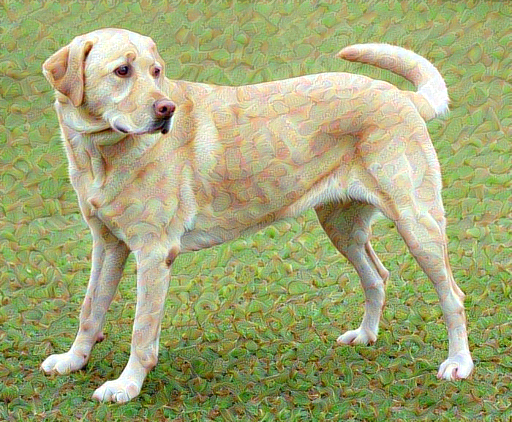

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

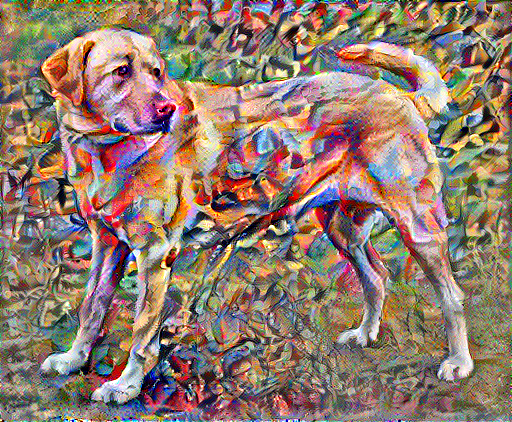

Train step: 1000
Total time: 3682.6


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
   for m in range(steps_per_epoch):
       step += 1
       train_step(image)
       print(".", end='')
   display.clear_output(wait=True)
   display.display(tensor_to_image(image))
   print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [29]:
def high_pass_x_y(image):
   x_var = image[:,:,1:,:] - image[:,:,:-1,:]
   y_var = image[:,1:,:,:] - image[:,:-1,:,:]

   return x_var, y_var

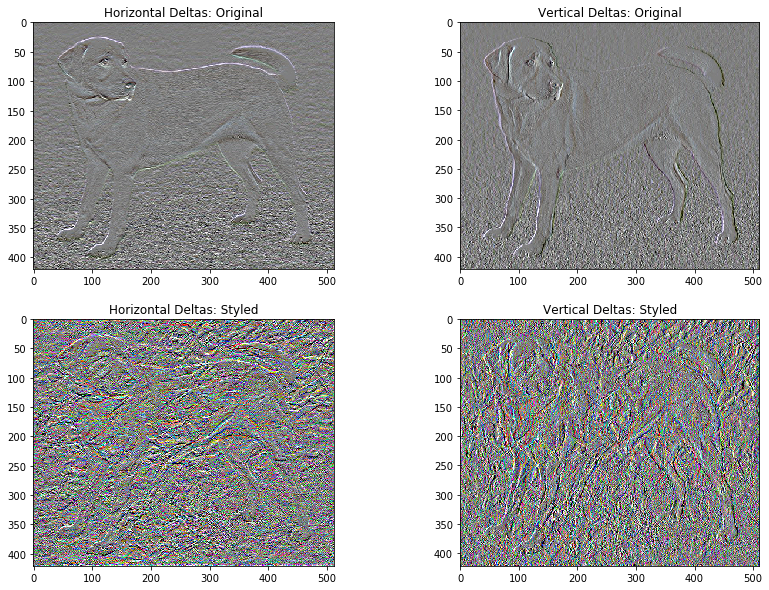

In [30]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

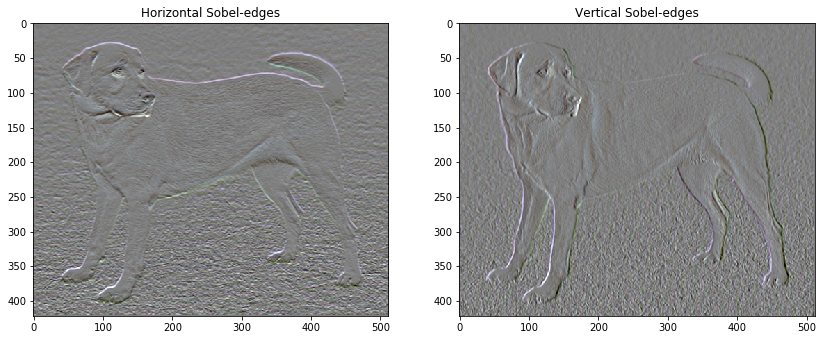

In [31]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [32]:
def total_variation_loss(image):
   x_deltas, y_deltas = high_pass_x_y(image)
   return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [33]:
total_variation_loss(image).numpy()

149472.97

In [34]:
total_variation_weight=30

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [36]:
image = tf.Variable(content_image)

In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Train step: 1000
Total time: 3453.4
